# Introduction

Ancestral sequence reconstruction (ASR) is a technique that employs sequence (and structure) information of extant proteins and a model of the evolutionary process to infer ancestral protein sequences and investigate their structural and functional properties. 

Phylogenetic inference algorithms compute the likelihood of a given tree by integrating over the ancestral states at internal nodes, however, in a ML framework it is also possible to infer what these ancestral (and thus un-observed) states are, given the observed states at terminal nodes, a tree topology, and a model of the evolutionary process. There are two broad categories of approaches to the problem of ASR. Marginal reconstruction assigns the most likely state to each ancestral sequence at a given site independently of the states reconstructed for other ancestral sequences at that site. Joint reconstruction, instead, finds an assignment of ancestral states throughout the tree that jointly maximises the likelihood of the observed data at that site.
For both these algorithms, I developed efficient and scalable python implementations, opportunely adapted to fit RAM55's expanded state-space, which I deployed on EMBL-EBI’s HPC infrastructure with up to $10^{4}$ simulation and inference processes running in parallel.

To test whether RAM55 allowed us to correctly infer unobserved ancestral amino acid states starting from data simulated under the model itself, I  simulated rotasequence alignments under RAM55  using trees with fixed topology and branch lengths scaled, in turn, according to a set of factors: \{0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 5\}. For each scaled tree, $100$ replicate alignments were generated: these included internal node rotasequences to be used as references against which inference accuracy was assessed. Masked versions of all sequences were also created, to allow 20-state model inference (i.e.~inference of ancestral amino acid sequence alone) using LG. 

The phylogenies from these simulations were then employed alongside RAM55 or LG to reconstruct ancestral states. Finally, reconstructed sequences were compared position-by-position \ins{against} the simulated reference sequences and the results reported in terms of percent sequence identity (percent correct inference). When RAM55 is used to reconstruct ancestral amino acids the model outputs a rotasequence which is then masked and compared to the reference, which also consists of a masked rotasequence and is similarly compared to the amino acid sequence inferred under LG.}

### Imports
Import libraries and write settings here.

In [42]:
# Data manipulation
import pandas as pd
import numpy as np
from Bio import Phylo

# Options for pandas
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 600
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



from dendropy import Tree, TaxonNamespace

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

# Set default font size
plt.rcParams['font.size'] = 24
import seaborn as sb
# Set default font size
sb.set(font_scale = .8)
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sb.set_style("white", rc=custom_style)


# Interactive Visualizations
# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)

# import cufflinks as cf
# cf.go_offline(connected=True)
# icf.set_config_file(theme='white')

# Analysis/Modeling
Do work here

In [ ]:
# copy data from EBI cluster
#!scp -po proxycommand="ssh -p 2244 ligate.ebi.ac.uk proxy %h" uperron@ebi-cli-001:/nfs/research1/goldman/umberto/bioinfotree/prj/ancestral_rotamers/dataset/full-lax2/alignment8x200x100_*AAseq_id.int_and_term.compare data/
# scp -po proxycommand="ssh -p 2244 ligate.ebi.ac.uk proxy %h" uperron@ebi-cli-001:/nfs/research1/goldman/umberto/bioinfotree/prj/ancestral_rotamers/dataset/full-lax2\$/alignment8x200x100_scaled-branches_evo_simulation.55xe55.1char_rotasequence.pre/*newick* data/

In [35]:
# parse AA ASR accuracy data for RAM55 and LG
RAM55_infile = "data/alignment8x200x100_scaled-branches_evo_simulation.\
55x55.1char_rotasequence.AAseq_id.int_and_term.compare"
RAM55_data = pd.read_csv(RAM55_infile, sep="\t", header=0, index_col=None)

# rename taxa preserving order and labels from previous viz
taxons = ["XuyvO","nTBpj","JVsBJ", 'ROOT', 
          'NGSDE', 'nJafA', 'LNiTV', 'lFySn', 
          'YGDQw', 'imvyn', 'nWmpf', 'icGte', 
          'uwKZF', 'SxtzJ','sAsFR']
new_taxons = ["Node A", "Node B", "Node C", "Node ROOT",
             "Node D", "Node E", "Node F", "Node G",
             "Node H", "Node I", "Node J", "Node K",
             "Node L", "Node M", "Node N"]
taxon_dict = dict(zip(taxons, new_taxons))
x = RAM55_data['scale'].drop_duplicates().values

RAM55_data["clean_taxon"] = RAM55_data["taxon"].apply(lambda x:taxon_dict[x])
LG_infile = "data/alignment8x200x100_scaled-branches_evo_simulation.\
55x55vLG.1char_rotasequence.AAseq_id.int_and_term.compare"
LG_data = pd.read_csv(LG_infile, sep="\t", header=0, index_col=None)
LG_data["clean_taxon"] = LG_data["taxon"].apply(lambda x:taxon_dict[x])

# label by model and algorithm
RAM55_data["model"] = ["RAM55"] * len(RAM55_data)
LG_data["model"] = ["LG"] * len(LG_data)
all_data_joint = pd.concat([RAM55_data, LG_data], ignore_index=True)
all_data_joint["method"] = ["joint"] * len(all_data_joint)

# same for marginal accuracy data for both models
RAM55_infile = "data/alignment8x200x100_scaled-branches_evo_simulation.55x55.\
1char_rotasequence.marginal.AAseq_id.int_and_term.compare"
RAM55_data = pd.read_csv(RAM55_infile, sep="\t", header=0, index_col=None)
RAM55_data["clean_taxon"] = RAM55_data["taxon"].apply(lambda x:taxon_dict[x])

LG_infile = "data/alignment8x200x100_scaled-branches_evo_simulation.55x55vLG.\
1char_rotasequence.marginal.AAseq_id.int_and_term.compare"
LG_data["clean_taxon"] = LG_data["taxon"].apply(lambda x:taxon_dict[x])

RAM55_data["model"] = ["RAM55"] * len(RAM55_data)
LG_data["model"] = ["LG"] * len(LG_data)

all_data_marg = pd.concat([RAM55_data, LG_data], ignore_index=True)
all_data_marg["method"] = ["marginal"] * len(all_data_marg)
# merge all
all_data = pd.concat([all_data_joint, all_data_marg], ignore_index=True)
all_data

scale  taxon  score clean_taxon  model    method
0      0.001   ROOT  100.0   Node ROOT  RAM55     joint
1      0.001  NGSDE   99.5      Node D  RAM55     joint
2      0.001  nTBpj   99.5      Node B  RAM55     joint
3      0.001  nJafA  100.0      Node E  RAM55     joint
4      0.001  LNiTV  100.0      Node F  RAM55     joint
...      ...    ...    ...         ...    ...       ...
59987  5.000  nWmpf   21.5      Node J     LG  marginal
59988  5.000  icGte   13.0      Node K     LG  marginal
59989  5.000  uwKZF   15.0      Node L     LG  marginal
59990  5.000  SxtzJ   24.5      Node M     LG  marginal
59991  5.000  sAsFR   15.5      Node N     LG  marginal

[59992 rows x 6 columns]

In [84]:
# calc node distance from root across scaled trees
# for a subset of scaling factors
treefiles = "scaled_0.1.newick.tmp,scaled_0.5.newick.tmp,scaled_1.newick.tmp,scaled_5.newick.tmp".split(",")
scaling_factors = '0.5,1,3'.split(",")
subset = all_data[all_data["scale"].isin(scaling_factors)]

arr = []
tns = TaxonNamespace(is_case_sensitive=True)
taxons = subset.taxon.unique()
scaling_factors = subset.scale.unique()
for f,treefile in zip(scaling_factors,treefiles):
    tree = Tree.get(path=f"data/{treefile}", schema='newick',
                     taxon_namespace=tns, case_sensitive_taxon_labels=True,
                     suppress_internal_node_taxa=False)
    for t in taxons:
        node = tree.find_node_with_taxon_label(t)
        # for ROOT
        if node == None:
            dist = .0
        else:
            dist = node.distance_from_root()
        arr.append([f, t, dist])
dist_df = pd.DataFrame(arr, columns=["scale", "taxon", "dist_root"])
dist_data = pd.merge(subset, dist_df, on=["scale", "taxon"])
dist_data

scale  taxon  score clean_taxon  model    method  dist_root
0        0.5   ROOT   88.0   Node ROOT  RAM55     joint   0.000000
1        0.5   ROOT   94.0   Node ROOT  RAM55     joint   0.000000
2        0.5   ROOT   90.5   Node ROOT  RAM55     joint   0.000000
3        0.5   ROOT   93.5   Node ROOT  RAM55     joint   0.000000
4        0.5   ROOT   90.5   Node ROOT  RAM55     joint   0.000000
...      ...    ...    ...         ...    ...       ...        ...
17995    3.0  sAsFR   25.5      Node N     LG  marginal   0.740822
17996    3.0  sAsFR   31.0      Node N     LG  marginal   0.740822
17997    3.0  sAsFR   30.5      Node N     LG  marginal   0.740822
17998    3.0  sAsFR   28.5      Node N     LG  marginal   0.740822
17999    3.0  sAsFR   27.5      Node N     LG  marginal   0.740822

[18000 rows x 7 columns]

# Results
Show graphs and stats here

Text(0.5, 0, 'Scaling factor')

Text(0, 0.5, 'Amino acids correctly reconstructed (%)')

Text(0.0, 1.0, 'a)')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 0, 'Branch length')

Text(0.0, 1.0, 'b)')

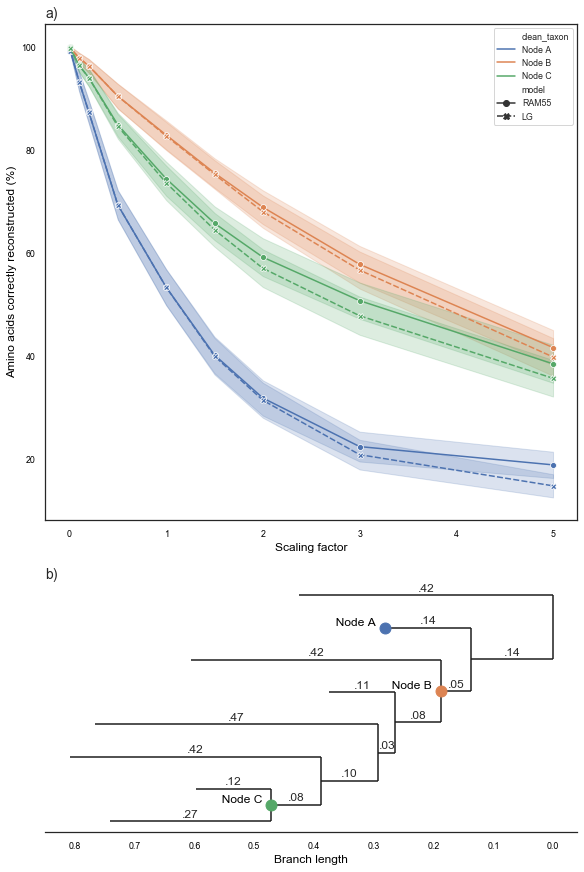

In [38]:
# joint AA reconstruction accuracy
selected_clean_taxons = ["Node A", "Node B", "Node C"]
selected_taxons = ["XuyvO","nTBpj","JVsBJ"]
plot_data = all_data[(all_data["clean_taxon"].isin(selected_clean_taxons))&(all_data["method"]=="joint")]

fig = plt.figure(constrained_layout=True, figsize=(8, 12))
heights = [2,1]
gs = fig.add_gridspec(ncols=1, nrows=2,
                    height_ratios=heights,
                    hspace=0.01)
plot_ax = fig.add_subplot(gs[0])
tree_ax = fig.add_subplot(gs[1])


# draw accuracy lineplot
sb.lineplot(x="scale", y="score",
            hue="clean_taxon", style="model",
            estimator="mean", ci="sd",
            markers=True, hue_order=selected_clean_taxons,
            data=plot_data, ax=plot_ax)

plot_ax.set_xlabel('Scaling factor', fontsize=12)
plot_ax.set_ylabel('Amino acids correctly reconstructed (%)', fontsize=12)
plot_ax.set_title("a)", loc="left", fontsize=14)
# draw tree with taxons highlighted
tree = Phylo.read("data/8_leaves_short-branches.newick", 'newick')
all_leaves = [x.name for x in tree.get_terminals()]

# Flip branches so deeper clades are displayed at top
#tree.ladderize()
brlen_dict = dict([(node, "{0:.2f}".format(node.branch_length))
                   for node in tree.find_clades(branch_length=True)])
Phylo.draw(tree, axes=tree_ax, do_show=False, branch_labels=brlen_dict)

current_palette = sb.color_palette()
color_dict = dict(zip(selected_taxons, current_palette))

tree_ax.set_autoscale_on(True)
pad = max(tree_ax.get_ylim()) / 75
for t in tree_ax.texts:
    if t._text[1:] in selected_taxons:
        taxon = t._text[1:]
        t._text = "  " + taxon_dict.get(taxon)
        #t._rotation = -15
        t._fontproperties._size = 12
        t._verticalalignment = "bottom"
        tree_ax.scatter(t._x, t._y, s=120, c=color_dict[taxon], 
                   marker="o", zorder=50)
        #t._y = t._y - pad
        t._x = t._x + pad *.8

    elif t._text[1:].isalpha():
        t._text = ""
    else:
        t._text = t._text[1:]
        t._fontproperties._size = 12
        t._y = t._y - pad

tree_ax.get_yaxis().set_visible(False)
tree_ax.invert_xaxis()
tree_ax.set_xlabel("Branch length", fontsize=12)
tree_ax.set_title("b)", loc="left", fontsize=14)
# Hide the right and top spines
tree_ax.spines['right'].set_visible(False)
tree_ax.spines['left'].set_visible(False)
tree_ax.spines['top'].set_visible(False)
plt.savefig("Figures/Ancestral_AA_vsLG_joint-rec_simulation_noboxes.pdf", 
            format='pdf', bbox_inches='tight', dpi=fig.dpi)

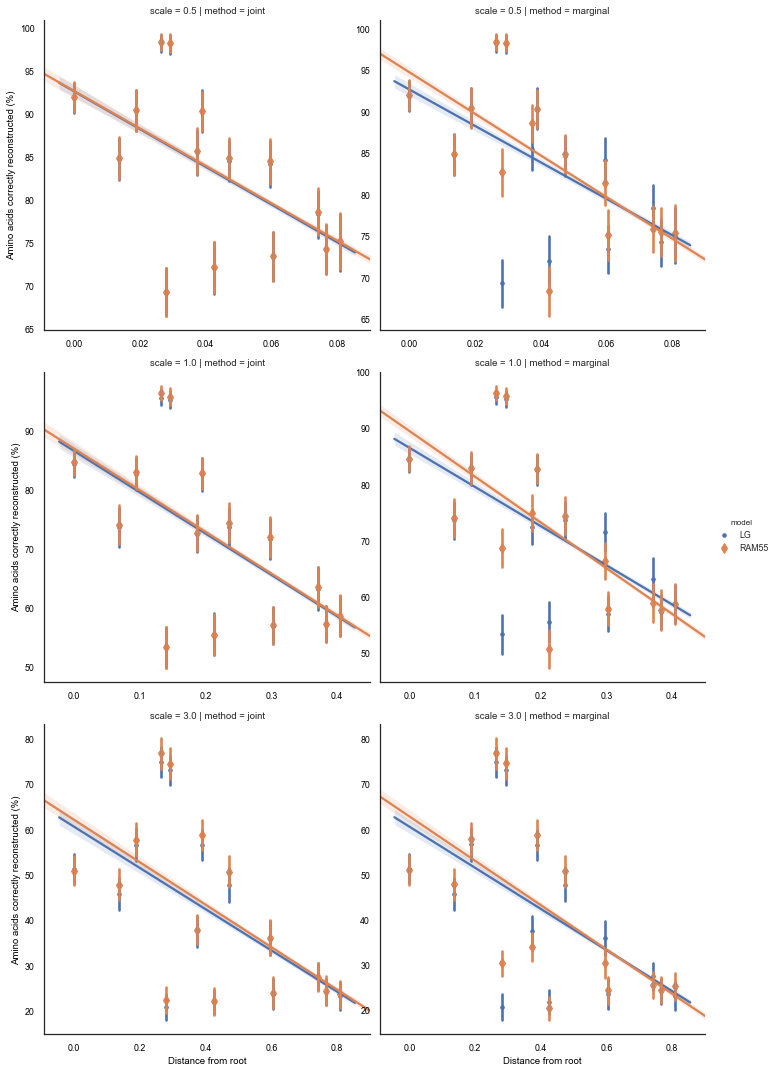

In [98]:
# accuracy vs distance from root for joint data
plot_data = dist_data#[dist_data["method"]=="joint"]
g = sb.lmplot(x="dist_root", y="score",
              hue="model", hue_order=["LG", "RAM55"],
              markers=[".", "d"],
              row="scale", col="method",
              x_estimator = np.mean, x_ci="sd",
              sharex=False, sharey=False,
              data=plot_data, height=5)

g.set_axis_labels("Distance from root", 
                       "Amino acids correctly reconstructed (%)")
g.fig.subplots_adjust(wspace=.03)

for ax in g.axes.flatten():
    # Only the 2nd and 4th axes have something in ax.texts
    if ax.texts:
        # This contains the right ylabel text
        txt = ax.texts[0]
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                txt.get_text(),
                transform=ax.transAxes,
                va='center',
                fontsize='14',
                rotation=-90)
        # Remove the original text
        ax.texts[0].remove()

fig = g.fig
plt.savefig("Figures/Ancestral_AA_vsLG_rec-accu_vs_depth.pdf", 
            format='pdf', bbox_inches='tight', dpi=fig.dpi)

Text(0.5, 0, 'Scaling factor')

Text(0, 0.5, 'Amino acids correctly reconstructed (%)')

Text(0.0, 1.0, 'a)')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 0, 'Branch length')

Text(0.0, 1.0, 'b)')

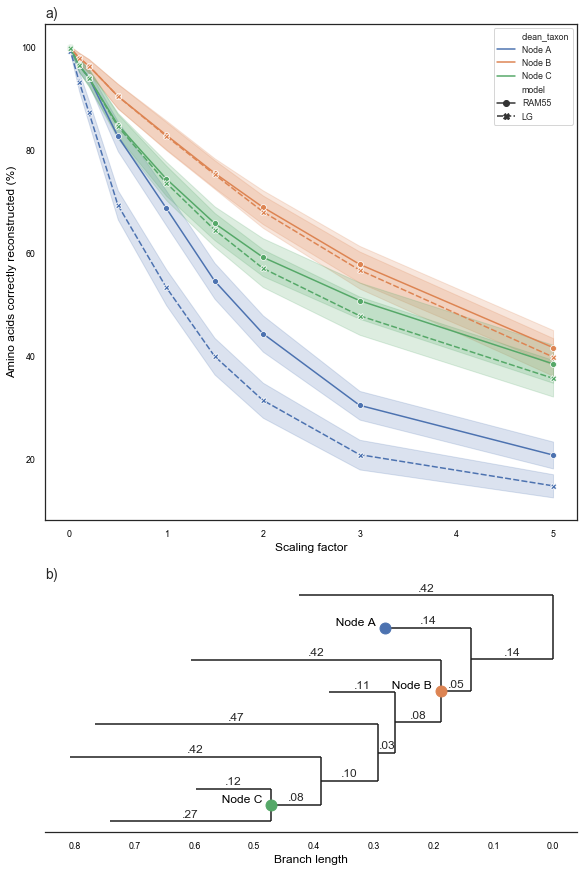

In [39]:
# marginal AA reconstruction accuracy
selected_clean_taxons = ["Node A", "Node B", "Node C"]
selected_taxons = ["XuyvO","nTBpj","JVsBJ"]
plot_data = all_data[(all_data["clean_taxon"].isin(selected_clean_taxons))&(all_data["method"]=="marginal")]

fig = plt.figure(constrained_layout=True, figsize=(8, 12))
heights = [2,1]
gs = fig.add_gridspec(ncols=1, nrows=2,
                    height_ratios=heights,
                    hspace=0.01)
plot_ax = fig.add_subplot(gs[0])
tree_ax = fig.add_subplot(gs[1])


# draw accuracy lineplot
sb.lineplot(x="scale", y="score",
            hue="clean_taxon", style="model",
            estimator="mean", ci="sd",
            markers=True, hue_order=selected_clean_taxons,
            data=plot_data, ax=plot_ax)

plot_ax.set_xlabel('Scaling factor', fontsize=12)
plot_ax.set_ylabel('Amino acids correctly reconstructed (%)', fontsize=12)
plot_ax.set_title("a)", loc="left", fontsize=14)
# draw tree with taxons highlighted
tree = Phylo.read("data/8_leaves_short-branches.newick", 'newick')
all_leaves = [x.name for x in tree.get_terminals()]

# Flip branches so deeper clades are displayed at top
#tree.ladderize()
brlen_dict = dict([(node, "{0:.2f}".format(node.branch_length))
                   for node in tree.find_clades(branch_length=True)])
Phylo.draw(tree, axes=tree_ax, do_show=False, branch_labels=brlen_dict)

current_palette = sb.color_palette()
color_dict = dict(zip(selected_taxons, current_palette))

tree_ax.set_autoscale_on(True)
pad = max(tree_ax.get_ylim()) / 75
for t in tree_ax.texts:
    if t._text[1:] in selected_taxons:
        taxon = t._text[1:]
        t._text = "  " + taxon_dict.get(taxon)
        #t._rotation = -15
        t._fontproperties._size = 12
        t._verticalalignment = "bottom"
        tree_ax.scatter(t._x, t._y, s=120, c=color_dict[taxon], 
                   marker="o", zorder=50)
        #t._y = t._y - pad
        t._x = t._x + pad *.8

    elif t._text[1:].isalpha():
        t._text = ""
    else:
        t._text = t._text[1:]
        t._fontproperties._size = 12
        t._y = t._y - pad


tree_ax.get_yaxis().set_visible(False)
tree_ax.invert_xaxis()
tree_ax.set_xlabel("Branch length", fontsize=12)
tree_ax.set_title("b)", loc="left", fontsize=14)
# Hide the right and top spines
tree_ax.spines['right'].set_visible(False)
tree_ax.spines['left'].set_visible(False)
tree_ax.spines['top'].set_visible(False)
plt.savefig("Figures/Ancestral_AA_vsLG_marginal-rec_simulation_noboxes.pdf", 
            format='pdf', bbox_inches='tight', dpi=fig.dpi)

Text(0.5, 0, 'Scaling factor')

Text(0, 0.5, 'Rotamer state correctly reconstructed (%)')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.1290666666666667, 2, ' Node ROOT')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 0, 'Branch length')

Text(0.0, 1.0, 'a)')

Text(0.0, 1.0, 'b)')

<Figure size 576x576 with 0 Axes>

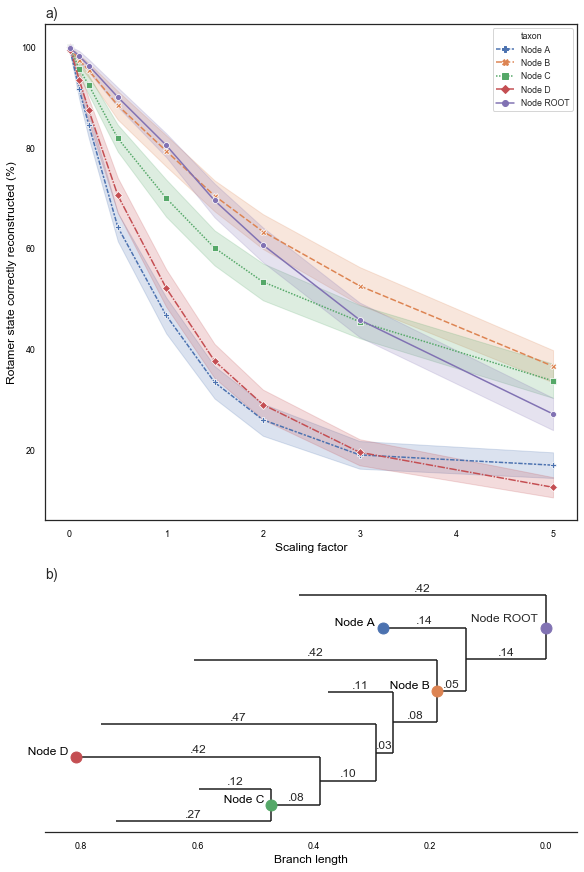

In [175]:
# rotamer sequence reconstruction accuracy (only for RAM55)
RAM55_infile = "data/alignment8x200x100_scaled-branches_evo_simulation.55x55.\
1char_rotasequence.seq_id.int_and_term.compare"

RAM55_data = pd.read_csv(RAM55_infile, sep="\t", header=0, index_col=None)
# select taxon subset
taxons = ["XuyvO","nTBpj","JVsBJ", "uwKZF", "ROOT"]
new_taxons = ["Node A", "Node B", "Node C", "Node D", "Node ROOT"]
taxon_dict = dict(zip(taxons, new_taxons))
RAM55_data = RAM55_data[RAM55_data["taxon"].isin(taxons)].replace(taxon_dict)
# group by scaling factor and taxon
RAM55_grouped = RAM55_data.groupby(['scale', 'taxon'], sort=False)
RAM55_data["model"] = ["RAM55"] * len(RAM55_data)


fig = plt.figure(constrained_layout=True, figsize=(8,8))
tree_ax , plot_ax= axes

fig = plt.figure(constrained_layout=True, figsize=(8, 12))
heights = [2,1]
gs = fig.add_gridspec(ncols=1, nrows=2,
                    height_ratios=heights,
                    hspace=0.01)
plot_ax = fig.add_subplot(gs[0])
tree_ax = fig.add_subplot(gs[1])

sb.lineplot(x="scale", y="score",
            hue="taxon", style="taxon",
            estimator="mean", ci="sd",
            markers=True, hue_order=new_taxons,
            data=RAM55_data, ax=plot_ax)

plot_ax.set_xlabel('Scaling factor', fontsize=12)
plot_ax.set_ylabel('Rotamer state correctly reconstructed (%)', fontsize=12)

# draw tree with taxons highlighted
tree = Phylo.read("data/8_leaves_short-branches.newick", 'newick')
all_leaves = [x.name for x in tree.get_terminals()]

# Flip branches so deeper clades are displayed at top
#tree.ladderize()

brlen_dict = dict([(node, "{0:.2f}".format(node.branch_length))
                   for node in tree.find_clades(branch_length=True)])
Phylo.draw(tree, axes=tree_ax, do_show=False, branch_labels=brlen_dict)

current_palette = sb.color_palette()
color_dict = dict(zip(taxons, current_palette))

tree_ax.set_autoscale_on(True)
pad = max(tree_ax.get_ylim()) / 75
# add marker for root node
root_y = 2
tree_ax.scatter(0, root_y, s=120, c=color_dict["ROOT"], 
                   marker="o", zorder=50)

tree_ax.text(pad *1.1, root_y, " Node ROOT", va="bottom", fontsize=12)
for t in tree_ax.texts:
    if t._text[1:] in taxons:
        taxon = t._text[1:]
        t._text = "  " + taxon_dict.get(taxon)
        #t._rotation = -15
        t._fontproperties._size = 12
        t._verticalalignment = "bottom"
        tree_ax.scatter(t._x, t._y, s=120, c=color_dict[taxon], 
                   marker="o", zorder=50)
        #t._y = t._y - pad
        t._x = t._x + pad *.8

    elif t._text[1:].isalpha():
        t._text = ""
    else:
        t._text = t._text[1:]
        t._fontproperties._size = 12
        t._y = t._y - pad

tree_ax.get_yaxis().set_visible(False)
tree_ax.invert_xaxis()
tree_ax.set_xlabel("Branch length", fontsize=12)
# Hide the right and top spines
tree_ax.spines['right'].set_visible(False)
tree_ax.spines['left'].set_visible(False)
tree_ax.spines['top'].set_visible(False)

plot_ax.set_title("a)", loc="left", fontsize=14)
tree_ax.set_title("b)", loc="left", fontsize=14)

plt.savefig("Figures/Ancestral_rotaseq_joint-rec_simulation_noboxes.pdf", 
            format='pdf', bbox_inches='tight', dpi=fig.dpi)